In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from argparse import Namespace
from glob import glob

from maskrcnn.postprocess.regress import plot_RD

In [2]:
AOI_IN_DIR = 'data/Experiment2/prev/aoi.csv'  # aoi.csv is sadly overwritten
LOG_IN_DIR = 'data/Experiment2/aoi_download_log.csv'
SAT_IN_DIR = 'data/Ambo/Pred/infer/'
OUT_FIG_DIR = 'data/Experiment2/Output/'

# set up visualization cfg
cfg = Namespace()
cfg.visual_score_cutoff = 0.9
cfg.xmax = 480
cfg.ymax = 770

In [3]:
df_chip = pd.merge(
    pd.read_csv(LOG_IN_DIR).loc[:, 'index'],
    pd.read_csv(AOI_IN_DIR),
    how='left', on='index')

In [4]:
# read satellite predictions
# from json annotations
df_ann = []
for file_name in glob(os.path.join(SAT_IN_DIR, '*.json')):
    with open(file_name, 'r') as f:
        df_ann += json.load(f)
df_ann = pd.DataFrame(df_ann)

# drop low score predictions
df_ann = df_ann.loc[df_ann['score'] > cfg.visual_score_cutoff, :]

# drop predictions on logos
df_ann = pd.concat([
    df_ann.reset_index(drop=True),
    pd.DataFrame(df_ann['bbox'].values.tolist(),
                 columns=['xmin', 'ymin', 'width', 'height'])],
    axis=1)
df_ann = df_ann.loc[~((df_ann['xmin'] > cfg.xmax) & (df_ann['ymin'] > cfg.ymax)), :]

In [5]:
df_chip = pd.merge(
    df_chip,
    df_ann.groupby(['image_id_str']).agg(
        sat_house=pd.NamedAgg(column='score', aggfunc='count'),
        sat_size_sum=pd.NamedAgg(column='area', aggfunc=np.nansum)),
    how='left', left_on='index', right_on='image_id_str')

In [6]:
df_chip['sat_house'] = df_chip['sat_house'].fillna(0)
df_chip['sat_size_sum'] = df_chip['sat_size_sum'].fillna(0)

In [7]:
# scale areas / distances
df_chip['sat_size_sum_pct'] = df_chip['sat_size_sum'] / (800 ** 2)
df_chip['sat_size_sum_m2'] = (df_chip['sat_size_sum'] *
    ((1.677e-3 / 800 * 111000) ** 2) * np.cos(-17.4 / 180 * np.pi))  # in sq meters

In [8]:
df_chip['bdist_1kbin'] = pd.cut((- df_chip['lat'] - 17.39) * 111,
                                bins=np.linspace(-25, 25, 51),
                                labels=np.linspace(-24.5, 24.5, 50)).astype('float')

In [9]:
df_scatter = df_chip.groupby('bdist_1kbin').agg(
    {'sat_size_sum_pct': 'mean', 'sat_size_sum_m2': 'sum', 'sat_house': 'sum'}).reset_index()
df_scatter['sat_size_mean'] = df_scatter['sat_size_sum_m2'] / df_scatter['sat_house']
df_scatter['sat_house_per_sqkm'] = df_scatter['sat_house'] / 25

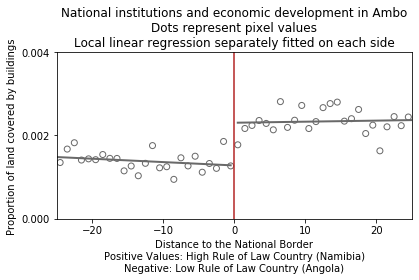

In [10]:
plot_RD(
    df=df_scatter,
    x='bdist_1kbin',
    y='sat_size_sum_pct',
    bandwidth=25,
    formula=('sat_size_sum_pct ~ (bdist_1kbin > 0) * bdist_1kbin'),
    ylim=(0, .004),
    yticks=[0, .002, .004],
    xlabel=('Distance to the National Border\n'
            'Positive Values: High Rule of Law Country (Namibia)\n'
            'Negative: Low Rule of Law Country (Angola)'),
    ylabel=('Proportion of land covered by buildings'),
    title=('National institutions and economic development in Ambo\n'
           'Dots represent pixel values\n'
           'Local linear regression separately fitted on each side'),
    out_dir=os.path.join(OUT_FIG_DIR, 'HouseSizeSum_Ambo.pdf'))
plt.show()

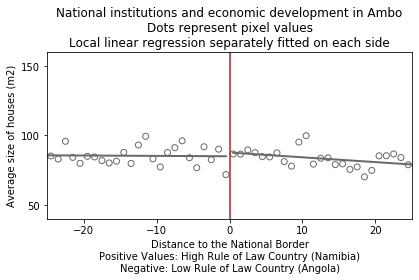

In [11]:
plot_RD(
    df=df_scatter,
    x='bdist_1kbin',
    y='sat_size_mean',
    bandwidth=25,
    formula=('sat_size_mean ~ (bdist_1kbin > 0) * bdist_1kbin'),
    ylim=(40, 160),
    yticks=[50, 100, 150],
    xlabel=('Distance to the National Border\n'
            'Positive Values: High Rule of Law Country (Namibia)\n'
            'Negative: Low Rule of Law Country (Angola)'),
    ylabel=('Average size of houses (m2)'),
    title=('National institutions and economic development in Ambo\n'
           'Dots represent pixel values\n'
           'Local linear regression separately fitted on each side'),
    out_dir=os.path.join(OUT_FIG_DIR, 'HouseSizeMean_Ambo.pdf'))
plt.show()

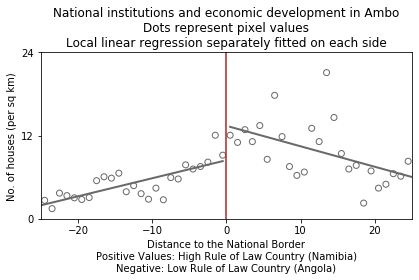

In [12]:
plot_RD(
    df=df_scatter,
    x='bdist_1kbin',
    y='sat_house_per_sqkm',
    bandwidth=25,
    formula=('sat_house_per_sqkm ~ (bdist_1kbin > 0) * bdist_1kbin'),
    ylim=(0, 24),
    yticks=[0, 12, 24],
    xlabel=('Distance to the National Border\n'
            'Positive Values: High Rule of Law Country (Namibia)\n'
            'Negative: Low Rule of Law Country (Angola)'),
    ylabel=('No. of houses (per sq km)'),
    title=('National institutions and economic development in Ambo\n'
           'Dots represent pixel values\n'
           'Local linear regression separately fitted on each side'),
    out_dir=os.path.join(OUT_FIG_DIR, 'HouseCount_Ambo.pdf'))
plt.show()